In [2]:
cd C:\Users\szdxl\OneDrive\Duke Assigment\Job Seeking\Collection_DS_takehome_challenges\data\email

C:\Users\szdxl\OneDrive\Duke Assigment\Job Seeking\Collection_DS_takehome_challenges\data\email


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
email_table=pd.read_csv('email_table.csv')
email_opened=pd.read_csv('email_opened_table.csv')
link_clicked=pd.read_csv('link_clicked_table.csv')

In [5]:
email_table.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [6]:
email_opened.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [7]:
link_clicked.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


# Data Processing

**Try to combine the data**

In [8]:
email_opened['open']=1
link_clicked['click']=1

In [9]:
data = pd.merge(left=email_table, right=email_opened, how='left', on='email_id')
data = pd.merge(left=data, right=link_clicked, how='left', on='email_id')
data.fillna(value=0, inplace=True)
data['open']=data['open'].astype(int)
data['click']=data['click'].astype(int)
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,open,click
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


**Encode some text variables into number**

In [10]:
data['paragraph'] = np.where(data.email_text == 'short_email', 2, 4)
del data['email_text']
data['is_personal'] = (data['email_version'] == 'personalized').astype(int)
del data['email_version']
weekdaysidx= {'Monday':1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
data['weekday']= data.weekday.map(weekdaysidx)
data.rename(columns={"user_past_purchases": 'purchase', 'user_country': 'country'}, inplace=True)

In [11]:
data.head()

,email_id,hour,weekday,country,purchase,open,click,paragraph,is_personal
0,85120,2,7,US,5,0,0,2,1
1,966622,12,7,UK,2,1,1,4,1
2,777221,11,3,US,2,0,0,4,1
3,493711,6,1,UK,1,0,0,2,0
4,106887,14,1,US,6,0,0,4,0


# Q1

**What percentage of users opened the email and what percentage clicked on the link within the email?**

In [12]:
print('Open Rate: {:.2f}%'.format(data['open'].mean()*100))
print('Click Rate: {:.2f}%'.format(data['click'].mean()*100))

Open Rate: 10.35%
Click Rate: 2.12%


# Q2

**The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?**

In [13]:
#According to the previous analysis we know the click rate is only around 2%. Keep in mind this is a unbalanced dataset.

In [14]:
conditions=[((data['open']==1) & (data['click'] !=1)), data['click']==1]
choices=['open', 'click']
response=pd.DataFrame(np.select(condlist=conditions,choicelist=choices,default='received'), columns=['response'])
response
data= pd.concat([data, response], axis=1)

**First use chi2 test to test the independence between features and targets**

In [15]:
data.head()

,email_id,hour,weekday,country,purchase,open,click,paragraph,is_personal,response
0,85120,2,7,US,5,0,0,2,1,received
1,966622,12,7,UK,2,1,1,4,1,click
2,777221,11,3,US,2,0,0,4,1,received
3,493711,6,1,UK,1,0,0,2,0,received
4,106887,14,1,US,6,0,0,4,0,received


In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

In [17]:
X=data.copy()

resp_label=LabelEncoder()
cnty_label=LabelEncoder()

y= resp_label.fit_transform(X.response)
del X['response']

X['country']=cnty_label.fit_transform(X.country)

study=['hour', 'weekday', 'country', 'purchase', 'paragraph', 'is_personal']
X=X[study]




In [18]:
chi2value, pvalue = chi2(X, y)

In [19]:
tmp=pd.DataFrame({'Chi2value': chi2value, 'p_value': pvalue}, index=study)
tmp.sort_values(by='Chi2value', ascending = False)

,Chi2value,p_value
purchase,3448.795660,0.000000e+00
country,378.554465,6.279750e-83
is_personal,316.752872,1.651915e-69
weekday,210.006087,2.498951e-46
hour,147.815921,7.983265e-33
paragraph,53.952439,1.924760e-12


**According to the Chi2 test (H0: independence), purchase, country and is_personal has stronger correlation**

**EDA of purchase**

In [20]:
data.head()

,email_id,hour,weekday,country,purchase,open,click,paragraph,is_personal,response
0,85120,2,7,US,5,0,0,2,1,received
1,966622,12,7,UK,2,1,1,4,1,click
2,777221,11,3,US,2,0,0,4,1,received
3,493711,6,1,UK,1,0,0,2,0,received
4,106887,14,1,US,6,0,0,4,0,received


Text(0.5, 1, 'Click Rate & Purchase')

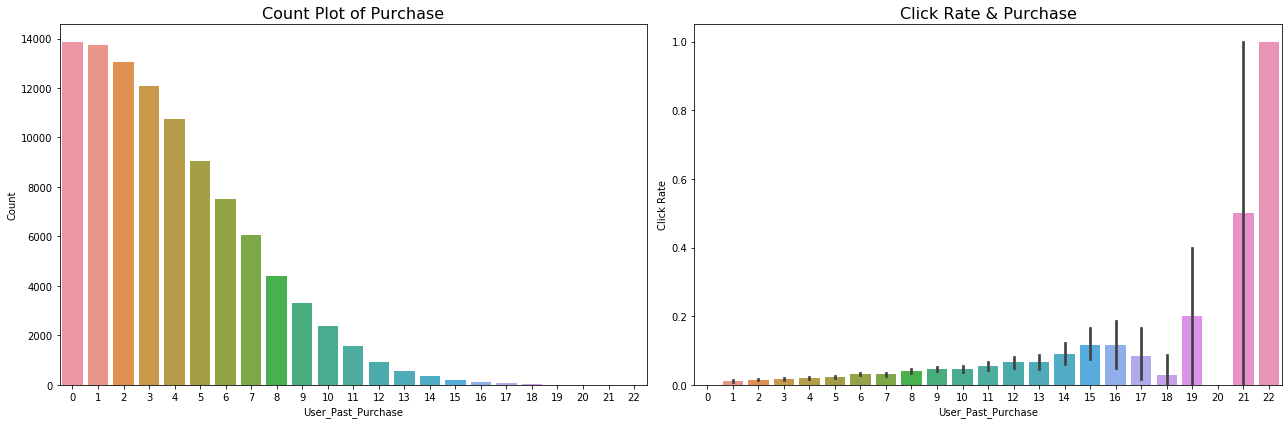

In [21]:
fig, ax= plt.subplots(nrows=1,  ncols=2, figsize=(18, 6))
sns.countplot(x='purchase', data=data, ax=ax[0])
ax[0].set_xlabel('User_Past_Purchase')
ax[0].set_ylabel('Count')
ax[0].set_title('Count Plot of Purchase', fontsize=16)



sns.barplot(x='purchase', y='click', data=data, ax=ax[1])
plt.tight_layout()
ax[1].set_xlabel('User_Past_Purchase')
ax[1].set_ylabel('Click Rate')
ax[1].set_title('Click Rate & Purchase', fontsize=16)



**EDA of country**

In [22]:
data.head()

,email_id,hour,weekday,country,purchase,open,click,paragraph,is_personal,response
0,85120,2,7,US,5,0,0,2,1,received
1,966622,12,7,UK,2,1,1,4,1,click
2,777221,11,3,US,2,0,0,4,1,received
3,493711,6,1,UK,1,0,0,2,0,received
4,106887,14,1,US,6,0,0,4,0,received


Text(0.5, 1, 'Click Rate & Country')

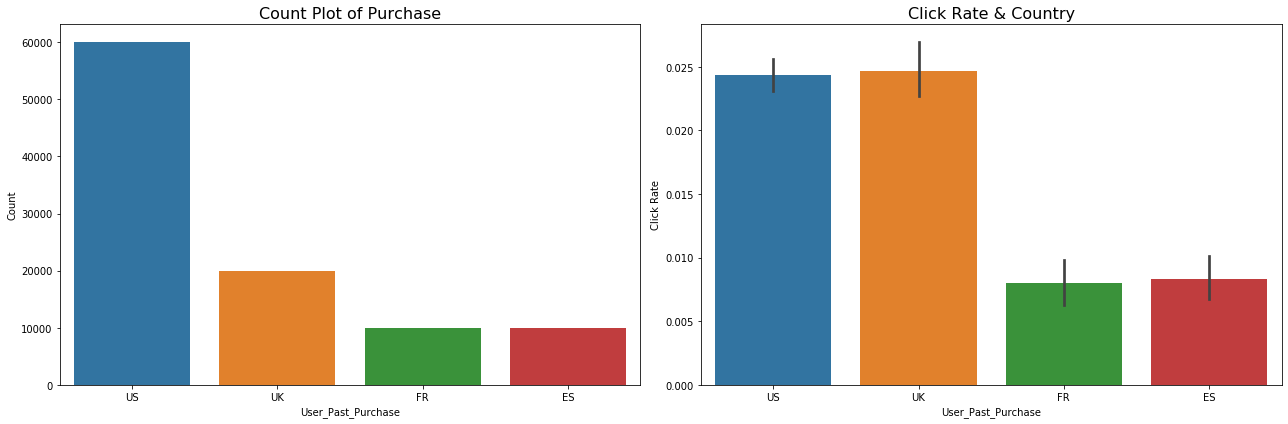

In [23]:
fig, ax= plt.subplots(nrows=1,  ncols=2, figsize=(18, 6))
sns.countplot(x='country', data=data, ax=ax[0])
ax[0].set_xlabel('User_Past_Purchase')
ax[0].set_ylabel('Count')
ax[0].set_title('Count Plot of Purchase', fontsize=16)



sns.barplot(x='country', y='click', data=data, ax=ax[1])
plt.tight_layout()
ax[1].set_xlabel('User_Past_Purchase')
ax[1].set_ylabel('Click Rate')
ax[1].set_title('Click Rate & Country', fontsize=16)



**EDA of Hour**

Text(0.5, 1, 'Click Rate & Country')

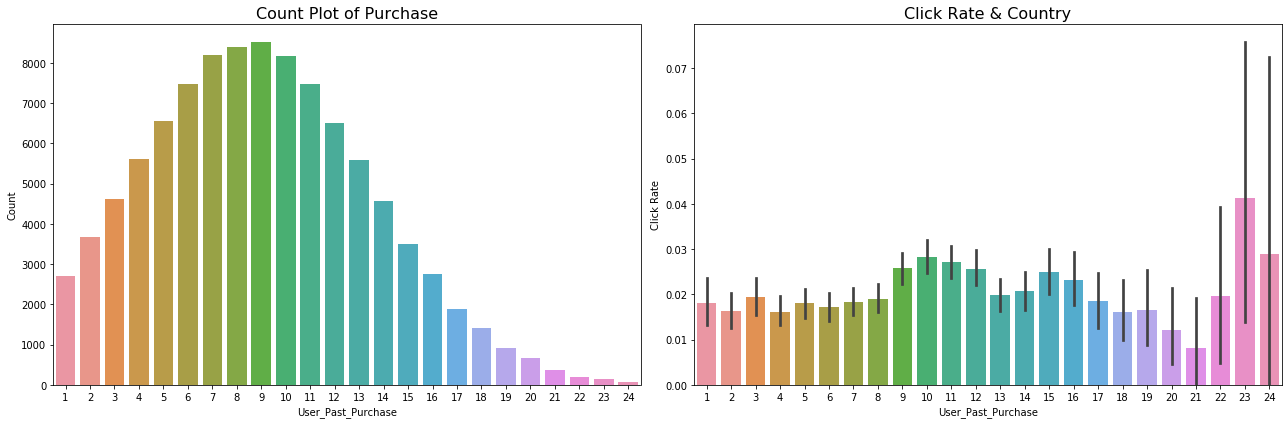

In [24]:
fig, ax= plt.subplots(nrows=1,  ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=data, ax=ax[0])
ax[0].set_xlabel('User_Past_Purchase')
ax[0].set_ylabel('Count')
ax[0].set_title('Count Plot of Purchase', fontsize=16)



sns.barplot(x='hour', y='click', data=data, ax=ax[1])
plt.tight_layout()
ax[1].set_xlabel('User_Past_Purchase')
ax[1].set_ylabel('Click Rate')
ax[1].set_title('Click Rate & Country', fontsize=16)



In [25]:
data.head()

,email_id,hour,weekday,country,purchase,open,click,paragraph,is_personal,response
0,85120,2,7,US,5,0,0,2,1,received
1,966622,12,7,UK,2,1,1,4,1,click
2,777221,11,3,US,2,0,0,4,1,received
3,493711,6,1,UK,1,0,0,2,0,received
4,106887,14,1,US,6,0,0,4,0,received


**EDA of weekday**

Text(0.5, 1.0, 'Click Rate & Weekday')

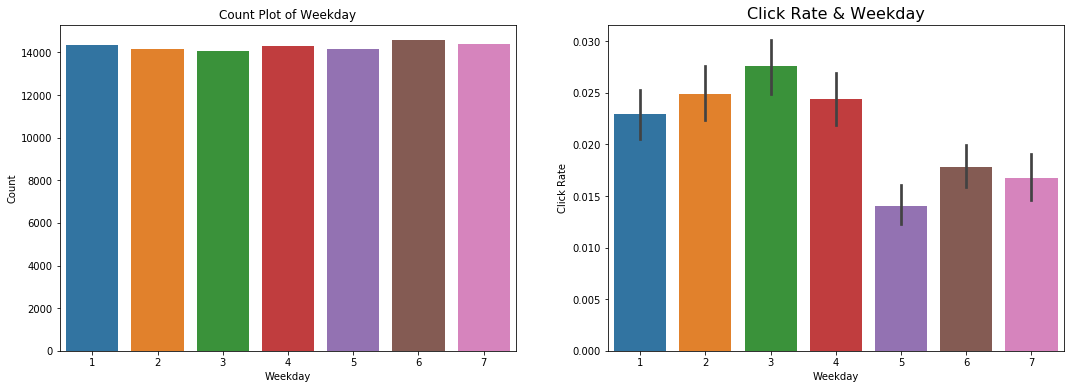

In [26]:
fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='weekday', data=data, ax=ax[0])
ax[0].set_xlabel('Weekday')
ax[0].set_ylabel('Count')
ax[0].set_title('Count Plot of Weekday')


sns.barplot(x='weekday', y='click', data=data, ax=ax[1])
ax[1].set_xlabel('Weekday')
ax[1].set_ylabel('Click Rate')
ax[1].set_title('Click Rate & Weekday', fontsize=16)

**OK Now let's build morel to do more quantitative check**

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_curve,precision_score,recall_score,auc,precision_recall_curve, roc_auc_score

In [28]:
model_data=data.copy()

In [29]:
model_data.head()

,email_id,hour,weekday,country,purchase,open,click,paragraph,is_personal,response
0,85120,2,7,US,5,0,0,2,1,received
1,966622,12,7,UK,2,1,1,4,1,click
2,777221,11,3,US,2,0,0,4,1,received
3,493711,6,1,UK,1,0,0,2,0,received
4,106887,14,1,US,6,0,0,4,0,received


In [30]:
feature=['hour', 'weekday', 'country', 'purchase', 'paragraph', 'is_personal']
target='click'
X=model_data[feature]
pd.get_dummies(X)
y=model_data[target]

cnty_label=LabelEncoder()
X['country']=cnty_label.fit_transform(X.country)

C:\App\Aconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2)

In [32]:
model=RandomForestClassifier(n_estimators=100, max_depth=10 )

In [33]:
X_train

,hour,weekday,country,purchase,paragraph,is_personal
19173,18,6,2,7,4,0
48993,13,2,0,1,4,0
60200,7,6,2,1,4,1
70656,11,7,3,4,4,0
40505,12,7,3,0,2,0
...,...,...,...,...,...,...
59598,4,3,3,2,2,1
61435,8,6,3,4,2,1
34242,10,2,3,3,2,1
68385,12,1,2,1,2,0


In [34]:
X_test

,hour,weekday,country,purchase,paragraph,is_personal
40968,4,7,3,1,2,0
31316,1,2,3,3,4,1
50566,10,2,3,9,4,1
16737,6,5,3,10,2,1
84694,8,3,0,4,2,0
...,...,...,...,...,...,...
83722,16,6,3,4,2,1
83637,17,6,3,0,4,0
31494,11,1,3,8,4,1
57546,8,7,3,6,2,1


In [35]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
prediction=model.predict(X_test)

In [37]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19575
           1       0.00      0.00      0.00       425

    accuracy                           0.98     20000
   macro avg       0.49      0.50      0.49     20000
weighted avg       0.96      0.98      0.97     20000



C:\App\Aconda\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
modelRF_AUC=roc_auc_score(y_test, prediction)
modelRF_AUC

0.5

In [39]:
data.groupby('click').count()

,email_id,hour,weekday,country,purchase,open,paragraph,is_personal,response
click,,,,,,,,,
0,97881,97881,97881,97881,97881,97881,97881,97881,97881
1,2119,2119,2119,2119,2119,2119,2119,2119,2119


In [40]:
fpr, tpr, thresholds=roc_curve(y_test, model.predict_proba(X_test)[:, 1])

In [41]:
ROC=pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds':thresholds})

,fpr,tpr,thresholds
2117,0.300026,0.628235,0.025133
2118,0.300179,0.628235,0.025127
2119,0.300281,0.628235,0.025105
2120,0.300434,0.628235,0.025104
2121,0.300639,0.628235,0.025098
...,...,...,...
4049,0.599285,0.880000,0.010821
4050,0.599336,0.880000,0.010811
4051,0.599591,0.880000,0.010808
4052,0.599796,0.880000,0.010806


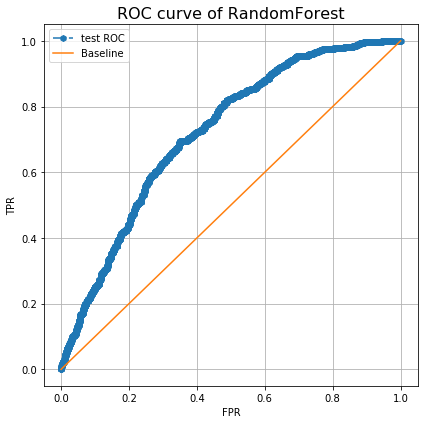

In [49]:
fig, ax=plt.subplots(figsize=(6, 6))
ax.grid(True)
ax.plot(fpr, tpr, label='test ROC', marker='h', linestyle='-.')
plt.plot([0,1], [0,1], label='Baseline')
ax.set_title('ROC curve of RandomForest', fontsize=16)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
ROC[(ROC['fpr'] < 0.6) & (ROC['fpr'] > 0.3)]
#According to the result, let's assume we set the threshold at 0.025113

,fpr,tpr,thresholds
2117,0.300026,0.628235,0.025133
2118,0.300179,0.628235,0.025127
2119,0.300281,0.628235,0.025105
2120,0.300434,0.628235,0.025104
2121,0.300639,0.628235,0.025098
...,...,...,...
4049,0.599285,0.880000,0.010821
4050,0.599336,0.880000,0.010811
4051,0.599591,0.880000,0.010808
4052,0.599796,0.880000,0.010806


In [76]:
a=model.predict_proba(X_test)[:, 1] >=0.025113+0
a


array([False,  True,  True, ...,  True,  True, False])

In [77]:
print(classification_report(y_test, a))
#So the test result strongly improved if threshold is set at 0.025113 instead of 0.5 

              precision    recall  f1-score   support

           0       0.99      0.70      0.82     19575
           1       0.04      0.63      0.08       425

    accuracy                           0.70     20000
   macro avg       0.52      0.66      0.45     20000
weighted avg       0.97      0.70      0.80     20000



In [78]:
sum(model.predict_proba(X_test)[:, 1] >=0.025113)

6144

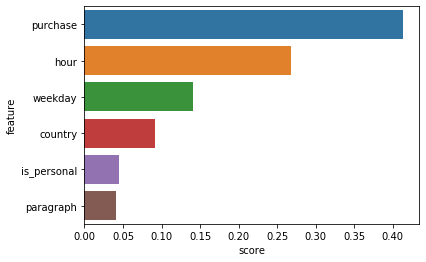

In [134]:
feature_important=pd.DataFrame({'feature':X_train.columns, 'score':model.feature_importances_})
feature_important.sort_values(by='score', inplace=True, ascending=False)
feature_important
sns.barplot(x='score', y='feature', data=feature_important)

**According to the model, the analysis is similar to the EDA**

*Suggestions:*

*1. Target on customer with high purchase to get higher possible CTR*

*2.Send email at 23 or 24 to get higher CTR*

*3. Wednesday seems can help*

# Q3

**By how much do you think your model would improve click through rate ( defined as # of
users who click on the link / total users who received the email). How would you test
that?**

In [79]:
print(classification_report(y_test, a))
#So the test result strongly improved if threshold is set at 0.025113 instead of 0.5 

              precision    recall  f1-score   support

           0       0.99      0.70      0.82     19575
           1       0.04      0.63      0.08       425

    accuracy                           0.70     20000
   macro avg       0.52      0.66      0.45     20000
weighted avg       0.97      0.70      0.80     20000



In [100]:
original_CTR=0.0212
new_CTR = 0.04
print('Saving Percentage\t{:.2f}%'.format((1-sum(model.predict_proba(X_test)[:, 1] >=0.025113)/len(data))*100))
print('CTR increase\t\t{:.2f}%'.format((new_CTR/original_CTR)*100))
original_CTR=0.0212
new_CTR = 0.04

Saving Percentage	93.86%
CTR increase		188.68%


# In conclusion

**The new strategy, which is only send email to people that my model believe will click, will save the cost by 93.86%, while increase the CTR by 188.68%**

**How to test that?**

**We need to do an A/b testing**

**1. Randomly split the group into control group and test group.**

**2. In the control group use the old strategy, and in the test group use the new strategy**

**3. Use t-test to see if the CTR in the test group is significantly higher than in the control group**